http://krasserm.github.io/2018/03/19/gaussian-processes/ 

GP from scratch using Numpy




## 1. Introduction

In supervised learning, MLE / MAP aims at inferring an optimal value of parameter at $\hat{\theta}$. Instead, if we want to infer the full posterior distribution $p(\theta \vert X,y)$ (***INCOMPLETE***) . Methods concerning variable (or infinite) number of parameters are dubbed 'non-parametric', in constrat to 'parametric' methods dealing with fixed number of parameters.

### GP

A Gaussian Process seeks to define a function in a fucntion-space, in contrast to inferences made in the weight-space, as in (network models?)  
...





*conditioning*

*noise*

### 1.1. Covariance and functions
https://www.ritchievink.com/blog/2019/02/01/an-intuitive-introduction-to-gaussian-processes/


### Radial Basis Function (RBF) Kernel

$$\kappa(\mathbf{x}_i, \mathbf{x}_j) = \sigma_f^2 \exp (-\frac{1}{2l^2}(\mathbf{x}_i-\mathbf{x}_j)^T(\mathbf{x}_i-\mathbf{x}_j))$$


$l$ : length parameter -- the larger the smoother  
$\sigma_f$ : vertical variation

### Squared Exponential Kernel
$$\kappa (x, x^{\prime}) = \exp(-\frac{(x-x^{\prime})^2}{2l^2})$$

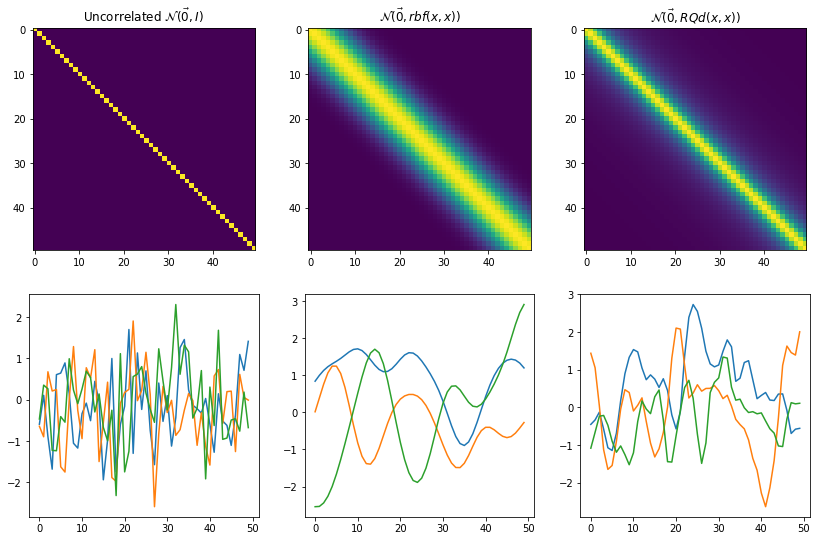

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


def rbf(x1, x2, l=1.0, sig_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        x1: Array of m points (m x d)
        x2: Array of n points (n x d)
        
    Returns:
        (m x n) matrix
    """
    # Note how the distance is calculated
    sqdist = np.sum(x1**2,1).reshape(-1,1) \
           + np.sum(x2**2,1) - 2  \
           * np.dot(x1, x2.T)
    return sig_f**2 * np.exp(-1/(2*l**2)*sqdist)


def rationalQuadratic(x1, x2, l=1, sigma=1.0, alpha=1.0):
    sqdist = np.sum(x1**2,1).reshape(-1,1) \
           + np.sum(x2**2,1) - 2  \
           * np.dot(x1, x2.T)
    return sigma**2*( 1 + sqdist/(2 * alpha * l**2))**(-alpha)

n = 50
x = np.linspace(0, 10, n).reshape(-1,1)
mu = np.zeros(x.shape)

cov1 = np.eye(50)
cov2 = rbf(x,x)
cov3 = rationalQuadratic(x, x, 0.44)

norm1 = stats.multivariate_normal(mean=mu.ravel(), cov=cov1, allow_singular=True)
norm2 = stats.multivariate_normal(mean=mu.ravel(), cov=cov2, allow_singular=True)
norm3 = stats.multivariate_normal(mean=np.zeros(n), cov=cov3, allow_singular=True)

fig, axs = plt.subplots(2,3)
fig.set_size_inches(14,9)

axs[0,0].imshow(cov1)
axs[0,1].imshow(cov2)
axs[0,2].imshow(cov3)
axs[1,0].plot(norm1.rvs(3).T)
axs[0,0].set_title(r"Uncorrelated $\mathcal{N}(\vec{0}, I)$")
axs[1,1].plot(norm2.rvs(3).T)
axs[0,1].set_title(r"$\mathcal{N}(\vec{0}, rbf(x, x))$")
axs[1,2].plot(norm3.rvs(3).T)
axs[0,2].set_title(r"$\mathcal{N}(\vec{0}, RQd(x, x))$")
plt.show()

The above example shows how covariance affects the shape of functions. It doesn't mean that we can generate arbitrary function by tweaking the covariance matrix, but numerous *meaningful* functions can be recovered by this approach. The goal of GP procedure is to find functions that satisfy prior and training data.

## 1.2 GP equations

Now the core of GP. Let $f$ known function outputs and $f_*$ unknown data points. The joint distribution $p(f,f_*) is

$$ \begin{pmatrix}
f \\ f_*
\end{pmatrix} = \mathcal{N}(\begin{bmatrix} \mu \\ \mu_* \end{bmatrix},
\begin{bmatrix} \mathbf{K} & \mathbf{K}_* \\ \mathbf{k}_*^T & \mathbf{K}_{**}\end{bmatrix})$$ 

, where $\mathbf{K} = k(x,x), \mathbf{K}_* = k(x,x_*), \mathbf{K_{* *}} = k(x_*,x_*)$.
When sizes of the training input data and new data are $N$ and $M$ respectively, $\mathbf{K}$ is a $N \times N$ matrix, $\mathbf{K_*}$ is $N \times M$, and $\mathbf{K_{* *}}$ is $M \times M$.  

We can calculate the conditional probability $f_* \vert f$ following eq.2.23 - 24 of RW06's chapter 2:

$$ \begin{equation} p(\mathbf{f_*}\vert \mathbf{X_*}, \mathbf{X},f = \mathcal{N}(f_* \vert \mu_*,\Sigma_*) \\
\mathbf{\mu_*} = \mathbf{K}_*^T \mathbf{K}^{-1}\mathbf{f} \\
\mathbf{\Sigma}_* = \mathbf{K}_{* *} - \mathbf{K}_*^T \mathbf{K}^{-1}\mathbf{K}_*
\end{equation}$$

or, taking noise into consideration, that is, $\mathbf{y} = \mathbf{f} + \mathbf{\epsilon}$ and the *noisy* predicition $\mathbf{y}_*$ is now

$$ \begin{equation} p(\mathbf{y_*}\vert \mathbf{X_*}, \mathbf{X},y)= \mathcal{N}(y_* \vert \mu_*,\Sigma_* + \sigma_y^2 \mathbf{I}) \\
\mathbf{\mu_*} = \mathbf{K}_*^T \mathbf{K}_y^{-1}\mathbf{y} \\
\mathbf{\Sigma}_* = \mathbf{K}_{* *} - \mathbf{K}_*^T \mathbf{K}_y^{-1}\mathbf{K}_*
\end{equation}$$

## 2. Implementation with NumPy

In [2]:
from matplotlib import animation, cm
from mpl_toolkits.mplot3d import Axes3D


# ------------------------------------------
#  GPs for regression utils
# ------------------------------------------
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape),
                    cmap=cm.coolwarm,
                    linewidth=0,
                    alpha=0.2,
                    antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train,
               c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

### 2.1 Kernel

We have implemented the RBF Kernel above.

In [3]:
kernel = rbf

### 2.2 Prior

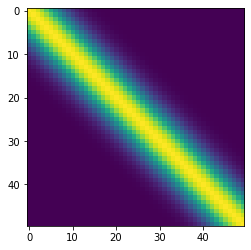

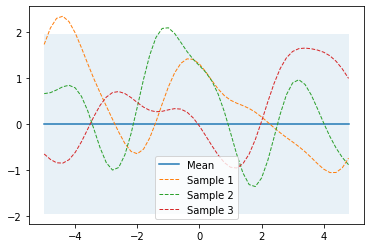

In [7]:
from numpy.random import default_rng

X = np.arange(-5, 5, 0.2).reshape(-1,1)

mu = np.zeros(X.shape) # zero mean is good enough
cov = kernel(X,X)

plt.imshow(cov)
plt.show()

# Draw three samples from the prior

randgen = default_rng()
samples = randgen.multivariate_normal(mu.ravel(), cov, 3)

plot_gp(mu, cov, X, samples=samples)

### 2.3 Prediction from noise-free training data

In [8]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sig_f=1.0, sig_y=1e-8, kernel=rbf):
    """
    Computes the sufficient statistics of the posterior distribution 
    from m training data (X_train, Y_train) and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d)
        X_train: Training locations (m x d)
        Y_train: Training targets (m x 1)
        l: Kernel length
        sig_f: Kernel vertical variation
        sif_y: Noise
        kerenl: RBF by default
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n)
    """
    
    K = kernel(X_train, X_train, l, sig_f) + sig_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sig_f)
    K_ss = kernel(X_s,X_s, l, sig_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

### 2.4 prediction from noise-free training data

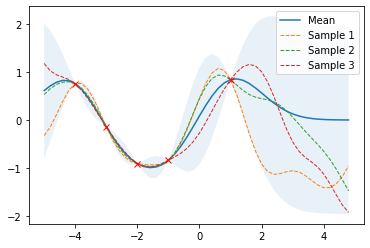

In [9]:
X_train = np.array([-4,-3,-2,-1,1]).reshape(-1,1)
Y_train = np.sin(X_train)

mu_s, cov_s = posterior(X, X_train, Y_train)

samples = randgen.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

### 2.5 prediction from noisy training data

In [10]:
np.random.randn(*X_train.shape) # == randn(5,1)

array([[-1.03383249],
       [ 0.74383987],
       [-2.16184034],
       [-1.36324302],
       [ 0.95737075]])

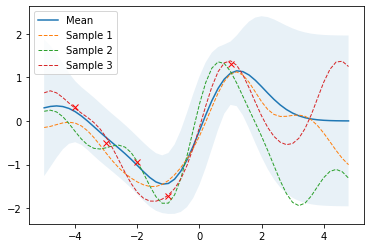

In [11]:
noise = 0.4

X_train = np.array([-4,-3,-2,-1,1]).reshape(-1,1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

mu_s, cov_s = posterior(X, X_train, Y_train, sig_y=noise)
# But, how do I know how large the noise amplitude is?


samples = randgen.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

## 3. Further examples

### 3.1. effect of kernel parameters and noise parameters

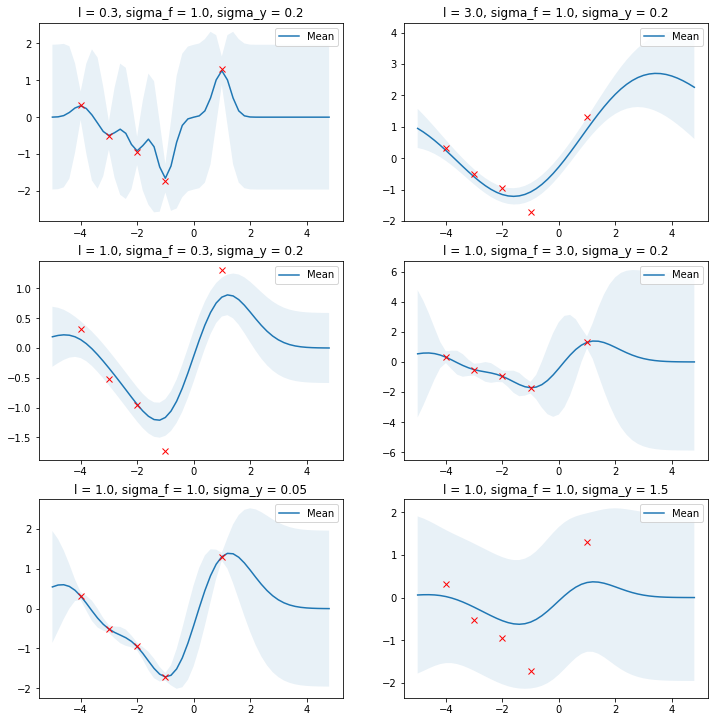

In [12]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sig_f, sig_y) in enumerate(params):
    mu_s, cov_s = posterior(X, X_train, Y_train, l=l, 
                            sig_f=sig_f, 
                            sig_y=sig_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sig_f}, sigma_y = {sig_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)


### Finding the optimal parameters 

An optimal set of parameters can be found by minimizing the log marginal likelihood (eq 2.29 of RW06):
$$\mathrm{log}p(\mathbf{y} \vert \mathbf{X}) = \mathrm{log}\mathcal{N}(\mathbf{y} \vert 0, \mathbf{K}_y) = - \frac{1}{2}\mathbf{y}^T\mathbf{K}_y^{-1}\mathbf{y} - \frac{1}{2}\mathrm{log}\mathopen|\mathbf{K}_y\mathclose| - \frac{N}{2}\mathrm{log}(2\pi)$$

### optimial parameters (l, $\sigma_f$) + $\sigma_y$


In [15]:
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular 
from scipy.optimize import minimize

#### Cholesky decomposition

Cholesky decomposition decomposes a Hermitian, positivie-definite matrix into a lower traingle matrix $\mathrm{L}$ and its conjugate transpose:
$$ A = [L][L]^T$$

In [52]:
def nll_fn(theta, X_train, Y_train, noise, naive=True):
    """
    Returns a function that computes 
    the negative log marginal likelihood for training data X_trainand Y_train
    and given noise level.
    
    Args:
        X_train: training points (m x d)
        Y_train: training targets (m x 1)
        noise : knonw noise level of Y_train
        naive: use a naive implementation of eq. 2.29 of RW06. 
               Or, use a more stable, algorithm 2.1 of RW06. 
    """
    
    Y_train = Y_train.ravel()
    K = kernel(X_train, X_train, l=theta[0], sig_f=theta[1]) \
            + noise**2 * np.eye(len(X_train))
        
    def nll_naive():
        return 1./2. * (Y_train.dot(inv(K).dot(Y_train)) \
                        + np.log(det(K)) + len(Y_train)*np.log(2*np.pi))
    
    def nll_stable():
        L = cholesky(K)
        
        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1,lower=False)
        
        return np.sum(np.log(np.diagonal(L))) + \
                0.5 * (Y_train.dot(S2) + len(x_train) * np.log(2*np.pi))
    
    if naive:
        return nll_naive()
    else:
        return nll_stable()

fun= lambda theta: nll_fn(theta, X_train=X_train, Y_train=Y_train, noise=noise)

      fun: 6.90167475599471
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.30926388e-06, 1.86517469e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([0.9009534, 1.0593822])


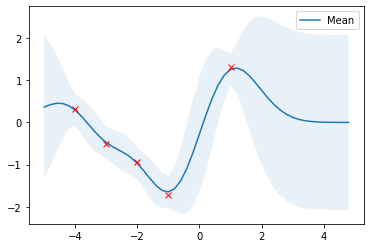

In [53]:
# Run the optimization procedure

res = minimize(fun, [1.5,0.8],
              bounds=((1e-5, None), (1e-5, None)),
              method='L-BFGS-B')

print(res)

l_opt, sigma_f_opt = res.x

# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, sig_f=sigma_f_opt, sig_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

In [55]:
def nll_fn_noise(theta, X_train, Y_train, naive=True):
    """
    Returns a function that computes 
    the negative log marginal likelihood for training data X_trainand Y_train
    and given noise level.
    
    Args:
        X_train: training points (m x d)
        Y_train: training targets (m x 1)
        naive: use a naive implementation of eq. 2.29 of RW06. 
               Or, use a more stable, algorithm 2.1 of RW06. 
    """
    
    Y_train = Y_train.ravel()
    K = kernel(X_train, X_train, l=theta[0], sig_f=theta[1]) \
                + theta[2]**2 * np.eye(len(X_train))
        
    def nll_naive():
        return 1./2. * (Y_train.dot(inv(K).dot(Y_train)) \
                        + np.log(det(K)) + len(Y_train)*np.log(2*np.pi))
    
    def nll_stable():
        L = cholesky(K)
        
        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1,lower=False)
        
        return np.sum(np.log(np.diagonal(L))) + \
                0.5 * (Y_train.dot(S2) + len(x_train) * np.log(2*np.pi))
    
    if naive:
        return nll_naive()
    else:
        return nll_stable()

fun_noise= lambda theta: nll_fn_noise(theta, X_train=X_train, Y_train=Y_train)

      fun: 6.893047456519966
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.86517467e-06, -3.55271370e-07,  3.90798505e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 84
      nit: 18
     njev: 21
   status: 0
  success: True
        x: array([8.75801149e-01, 1.07554594e+00, 1.00000000e-05])


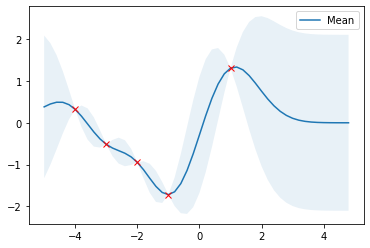

In [56]:
# Run the optimization procedure

res_noise = minimize(fun_noise, [1.5,0.8, 0.2],
              bounds=((1e-5, None), (1e-5, None), (1e-5, 2.)),
              method='L-BFGS-B')

print(res_noise)

l_opt, sigma_f_opt, noise = res_noise.x

# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, sig_f=sigma_f_opt, sig_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

optimizing without predefined noise level seems to overfit. 

### Higher dimension example

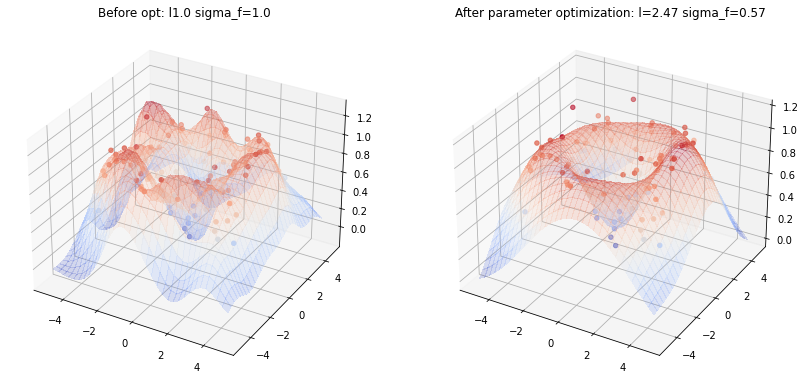

In [74]:
noise_2d = 0.1

rx, ry = np.arange(-5,5,0.3), np.arange(-5,5,0.3)
gx, gy = np.meshgrid(rx,ry)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train= np.random.uniform(-4, 4, (100,2))
Y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1)) + \
             noise_2d * np.random.randn(len(X_2d_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior(X_2d, X_2d_train, Y_2d_train, sig_y=noise_2d)
plot_gp_2D(gx, gy, mu_s, X_2d_train, Y_2d_train,
          f'Before opt: l{1.00} sigma_f={1.00}', 1)

# optimize kernel parameters l(length) and sigma_f(vertical variance)
fun= lambda theta: nll_fn(theta, X_train=X_2d_train, Y_train=Y_2d_train, noise=noise_2d)
res = minimize(fun, [1.5,0.8],
              bounds=((1e-5, None), (1e-5, None)),
              method='L-BFGS-B')

mu_s, _ = posterior(X_2d, X_2d_train, Y_2d_train, *res.x, sig_y=noise_2d)
plot_gp_2D(gx, gy, mu_s, X_2d_train, Y_2d_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

## Libraries - SKlearn

In [76]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

### Composing kernels

Gaussian Processes are Bayesian, which means you need to compute the conditional $P(B|A)$ and the marginal $P(A)$ (or $P(B)$) probability. 

$$ P(A|B) = \frac{P(B|A) P(A)}{P(B)} $$

An important property of a Gaussian distribution is that, both the conditional probability and the marginal probability of a multivariate Gaussian is another, lower-dimentional multivariate Gaussian.


Remember, integrating along a set of parameters == marginalization  
cutting through a (hyper)plane defined by a set of parameters == conditioning.

(draw example cases for 2D multivariate Gaussian -> 1D Gaussian)

### Functions are multivariate Gaussians

